# Twitter Sentiment Analysis for ChatGPT

## 0. Notes

* This project is based on the tweets about ChatGPT after the announcement about release of GPT-4. 
* The aim of the project is to determine the thoughts and tendencies of twitter users about ChatGPT.


## 1. Scraping Tweets Data

## 2. Readind Data and Exploratory Data Analysis

* The data consists of 100,000 tweets (include duplicates) in English containing the word "chatgpt" between 2023-03-18 and 2023-03-21.
* In the shared data,  usernames are masked, tags (@username) and links in the tweet are deleted.
* Variables;
    * ID: unique tweet id
    * Date: date the tweet was sent
    * Username: username of the person who tweeted (masked for this data and non-real ids are generated)
    * Tweet: content of the tweet (tags and links deleted)
    * ReplyCount: number of replies to tweets
    * RetweetCount: number of retweets to tweets
    * LikeCount: number of likes to tweets
    * QuotesCount: number of quotes to tweets

### 2.1 Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import re
import emoji
from tqdm.notebook import tqdm
import warnings

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Set display options
pd.set_option('display.float_format', '{:.4f}'.format)

# Ignore warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.2 Importing Data and First Impressions

In [2]:
# Reading dataset
df = pd.read_csv("/kaggle/input/tweets-about-chatgpt-march-2023/chatgpt-tweets-data-20230310-20230322.csv")
# Number of tweets
print("The number of unique tweets:", df.shape[0])

The number of unique tweets: 98759


In [3]:
df.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98759 entries, 0 to 98758
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            98759 non-null  int64 
 1   Date          98759 non-null  object
 2   Username      98759 non-null  object
 3   Tweet         98759 non-null  object
 4   ReplyCount    98759 non-null  int64 
 5   RetweetCount  98759 non-null  int64 
 6   LikeCount     98759 non-null  int64 
 7   QuoteCount    98759 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 6.0+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,98759.0000,1637481406058415616.0000,563281176533013.5000,1636521747540242432.0000,1636926715759888384.0000,1637527761219645440.0000,1637975215293546496.0000,1638329623946878976.0000
ReplyCount,98759.0000,1.3467,32.8560,0.0000,0.0000,0.0000,1.0000,4984.0000
RetweetCount,98759.0000,1.3948,35.9637,0.0000,0.0000,0.0000,0.0000,4076.0000
LikeCount,98759.0000,9.7873,245.5766,0.0000,0.0000,0.0000,2.0000,36112.0000
QuoteCount,98759.0000,0.2590,19.7567,0.0000,0.0000,0.0000,0.0000,5415.0000


### 2.3 Generating New Time Variables

In [6]:
# Generating new time variables
df['Date'] = pd.to_datetime(df['Date'])
df['OnlyDate'] = df['Date'].dt.date
df['OnlyDate'] = pd.to_datetime(df['OnlyDate'])
df['OnlyHour'] = df['Date'].dt.hour
df['OnlyMin'] = df['Date'].dt.minute

In [7]:
df.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount,OnlyDate,OnlyHour,OnlyMin
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0,2023-03-21,23,59
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0,2023-03-21,23,59
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0,2023-03-21,23,59
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0,2023-03-21,23,59
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0,2023-03-21,23,59


In [8]:
df['OnlyDate'].value_counts()

2023-03-21    25074
2023-03-17    22923
2023-03-20    20790
2023-03-19    15187
2023-03-18    14785
Name: OnlyDate, dtype: int64

### 2.4 First Exploratory Data Analysis Works

In [9]:
def plot_time_variable(col, ylim_lower = 10000, ylim_upper = 30000):
    """
    Given a pandas dataframe and the name of a time column, this function will plot a line graph of time counts
    using the specified column.
    
    Parameters:
    -----------
    col : str
        The name of a column in the pandas dataframe.
    """
    
    if df[col].dtype == "int64":
        time_variable_counts = df[col].value_counts().sort_index()
        
    else:
        # calculate the count of dates using resample
        time_variable_counts = df[col].value_counts().resample('D').sum()

    # set the size of the figure
    plt.figure(figsize=(12, 8))

    # plot the counts using a line graph
    time_variable_counts.plot(kind='line', marker='o', markersize=8)

    # set the y-axis limits to a specific range
    plt.ylim(ylim_lower, ylim_upper)

    # add graph labels and titles
    plt.title(f"{col} Counts", fontsize=16)
    plt.xlabel(f"{col}", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=45, ha='right') # rotate x-axis labels for readability
    plt.grid(axis='y', linestyle='--')

    # display the graph
    plt.show()

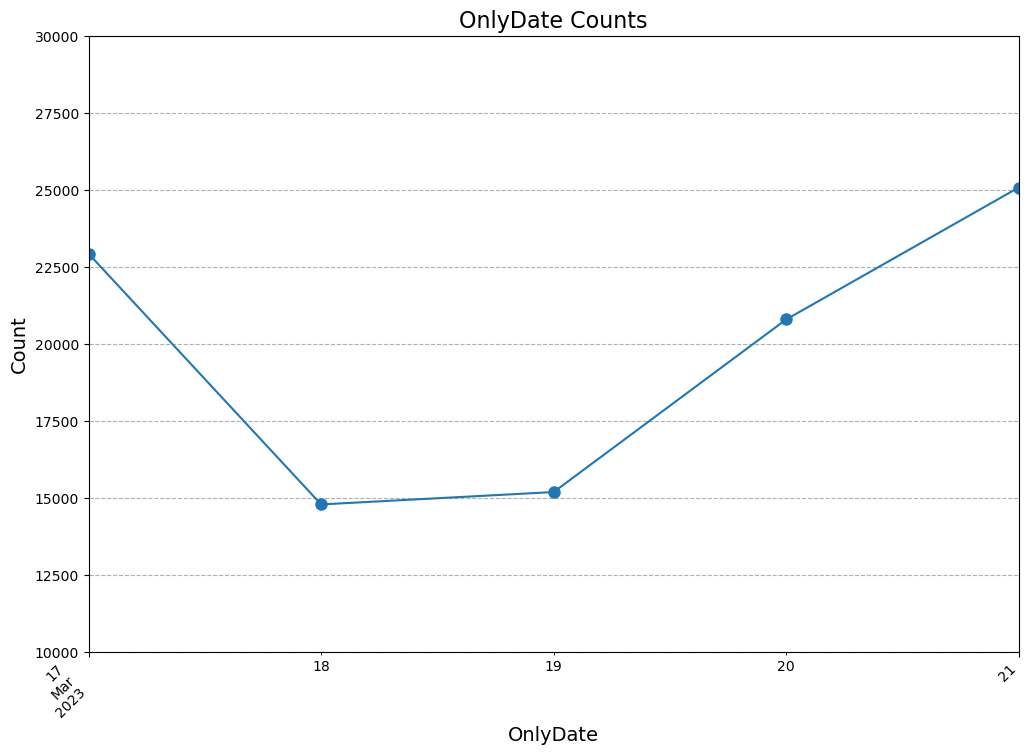

In [10]:
plot_time_variable('OnlyDate')

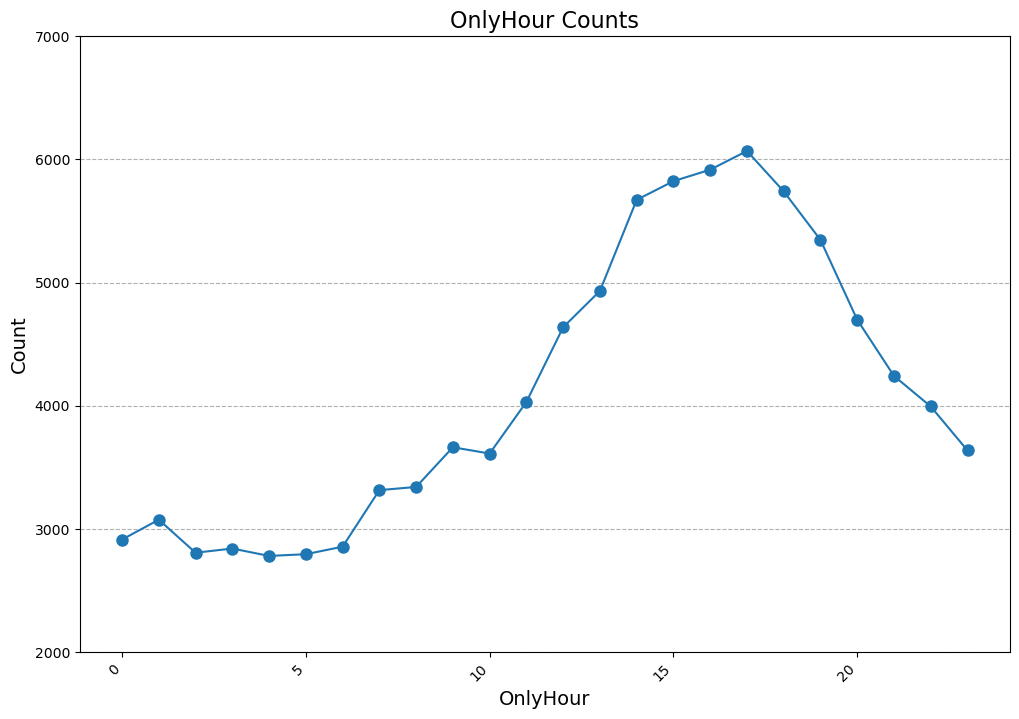

In [11]:
plot_time_variable('OnlyHour', 2000, 7000)

In [12]:
def get_top_words(df, column_name, top_n=20):
    # get the list of tweets from the specified column
    tweets = df[column_name].astype(str).tolist()
    
    # tokenize all the words from the tweets
    words = []
    for tweet in tweets:
        words += word_tokenize(tweet.lower())  # convert to lowercase and tokenize the tweet

    # calculate the frequency distribution of words
    freq_dist = FreqDist(words)

    # return the top n most common words
    return freq_dist.most_common(top_n)

In [13]:
get_top_words(df, "Tweet", 20)

[('#', 105632),
 ('chatgpt', 87067),
 ('.', 80519),
 (',', 64765),
 ('the', 64051),
 ('to', 61971),
 ('a', 42436),
 ('and', 42056),
 ('it', 36925),
 ('i', 36728),
 ('is', 34155),
 ('of', 32170),
 ('for', 24735),
 ('in', 22745),
 ('you', 22543),
 ('ai', 21750),
 (':', 19586),
 ('?', 19311),
 ('that', 18487),
 ('with', 17935)]

## 3. Data Preprocessing for Sentiment Analysis and Model

* Trained model from huggingface
* https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest

### 3.1 Loading Model from HuggingFace and Creating Pipeline

In [14]:
# load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

# create pipeline
sa = pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 3.2 Preprocessing for Sentiment Labeling and Scoring

In [15]:
def preprocess_word(word):
    # Remove punctuation
    #word = word.strip('\'"?!,.():;')
    
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word


def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)


def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)|😉', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet


def remove_emoji(tweet):
    return emoji.replace_emoji(tweet, replace=" ")


def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    
    #Clean only digits
    tweet = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", tweet)
    
    # Replaces URLs with the word URL
    #tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', tweet)
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', tweet)
    
    # Replace @handle with the word USER_MENTION
    #tweet = re.sub(r'@[\S]+', 'USER_MENTION', tweet)
    tweet = re.sub(r'@[\S]+', '', tweet)
    
    # Replaces #hashtag with hashtag
    #tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    tweet = re.sub(r'#(\S+)', '', tweet)
    
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')

    # Replace emojis with either EMO_POS or EMO_NEG
    #tweet = handle_emojis(tweet)

    #remove emojis
    tweet = remove_emoji(tweet)
    
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    words = tweet.split()

    for word in words:
        word = preprocess_word(word)
        processed_tweet.append(word)

    return ' '.join(processed_tweet)

In [16]:
index = 2019
print(df.loc[index].Tweet)
p = sa(df.loc[index].Tweet)
print(p)

Kind of wild that Google just admits their training dataset is your gmail &amp; you’re not getting compensated for any of it.
Considering the amount of data that includes it  guarantees that  if Bard can give ChatGPT a fight, we just entrenched 2 old monopolies &amp; have a legal case
[{'label': 'negative', 'score': 0.6108609437942505}]


In [17]:
pre_twit = preprocess_tweet(df.loc[index].Tweet)
print(pre_twit)
p = sa(pre_twit)
print(p)

kind of wild that google just admits their training dataset is your gmail &amp; you’re not getting compensated for any of it. considering the amount of data that includes it guarantees that if bard can give chatgpt a fight, we just entrenched old monopolies &amp; have a legal case
[{'label': 'negative', 'score': 0.6796213984489441}]


In [18]:
df["processed_tweet"] = df["Tweet"].apply(preprocess_tweet)

In [19]:
df.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount,OnlyDate,OnlyHour,OnlyMin,processed_tweet
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0,2023-03-21,23,59,chatgpt is another woke machine.
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0,2023-03-21,23,59,"of the atlantic, or only near the atla more to..."
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0,2023-03-21,23,59,this thread is saved to your notion database. ...
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0,2023-03-21,23,59,prompt ai – chatgpt
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0,2023-03-21,23,59,just had some interesting conversations with g...


## 4. Sentiment Analysis

* Since the labeling and scoring process takes a long time, I loaded a more executed and saved version of the data.

In [20]:
# df["sentiment_label"] = "-"
# df["sentiment_score"] = -1

# df_part_1 = df[:25000]
# df_part_2 = df[25000:50000]
# df_part_3 = df[50000:75000]
# df_part_4 = df[75000:]

# df_part_1[["sentiment_label", "sentiment_score"]] = df_part_1["processed_tweet"].progress_apply(get_sentiment_analysis) #1 hours 6 minutes
# df_part_2[["sentiment_label", "sentiment_score"]] = df_part_2["processed_tweet"].progress_apply(get_sentiment_analysis) #1 hours 3 minutes
# df_part_3[["sentiment_label", "sentiment_score"]] = df_part_3["processed_tweet"].progress_apply(get_sentiment_analysis) #1 hours 3 minutes
# df_part_4[["sentiment_label", "sentiment_score"]] = df_part_4["processed_tweet"].progress_apply(get_sentiment_analysis) # 59 minutes

# df = pd.concat([df_part_1, df_part_2, df_part_3, df_part_4], axis=0)

df = pd.read_csv("/kaggle/input/tweets-about-chatgpt-march-2023/chatgpt-tweets-data-20230310-20230322-processed.csv")

In [21]:
# remove punctuation marks
df['processed_tweet'] = df['processed_tweet'].str.replace('[^\w\s]', '')

df.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount,OnlyDate,OnlyHour,OnlyMin,processed_tweet,sentiment_label,sentiment_score
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0,2023-03-21,23,59,chatgpt is another woke machine,negative,0.8628
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0,2023-03-21,23,59,of the atlantic or only near the atla more to ...,neutral,0.8373
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0,2023-03-21,23,59,this thread is saved to your notion database t...,neutral,0.8854
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0,2023-03-21,23,59,prompt ai chatgpt,neutral,0.8958
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0,2023-03-21,23,59,just had some interesting conversations with g...,positive,0.9558


### 4.1 Label Frequencies

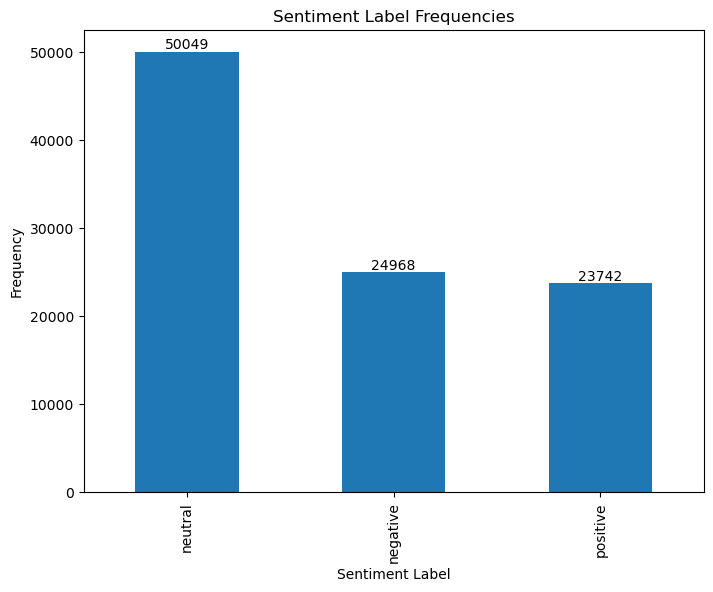

In [22]:
# count the frequency of each sentiment label
sentiment_counts = df.sentiment_label.value_counts()

# create a column plot
fig, ax = plt.subplots(figsize=(8,6))
sentiment_counts.plot(kind='bar', ax=ax)

# set the plot title and axis labels
ax.set_title('Sentiment Label Frequencies')
ax.set_xlabel('Sentiment Label')
ax.set_ylabel('Frequency')

# add data labels to the top of each column
for i, freq in enumerate(sentiment_counts):
    ax.text(i, freq, str(freq), ha='center', va='bottom')

# display the plot
plt.show()

### 4.2 Removing Stopwords

In [23]:
# Extracting english stopwords from processed tweets
sw = stopwords.words('english')
df['processed_tweet_without_stopwords'] = df['processed_tweet'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [24]:
df.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount,OnlyDate,OnlyHour,OnlyMin,processed_tweet,sentiment_label,sentiment_score,processed_tweet_without_stopwords
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0,2023-03-21,23,59,chatgpt is another woke machine,negative,0.8628,chatgpt another woke machine
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0,2023-03-21,23,59,of the atlantic or only near the atla more to ...,neutral,0.8373,atlantic near atla greenness th
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0,2023-03-21,23,59,this thread is saved to your notion database t...,neutral,0.8854,thread saved notion database tags chatgpt
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0,2023-03-21,23,59,prompt ai chatgpt,neutral,0.8958,prompt ai chatgpt
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0,2023-03-21,23,59,just had some interesting conversations with g...,positive,0.9558,interesting conversations googles bard appears...


### 4.3 Creating New Dataframes based Label and Most Frequent Words

In [25]:
# create new data frames for each sentiment label
df_positive = df[df["sentiment_label"] == "positive"]
df_neutral = df[df["sentiment_label"] == "neutral"]
df_negative = df[df["sentiment_label"] == "negative"]

In [26]:
# with stopwords
#get_top_words(df_positive, "processed_tweet", 20)

# without stopwords
get_top_words(df_positive, "processed_tweet_without_stopwords", 20)

[('chatgpt', 14753),
 ('ai', 4456),
 ('gpt', 2602),
 ('chat', 2526),
 ('gpt4', 2148),
 ('like', 2049),
 ('use', 1952),
 ('new', 1674),
 ('using', 1536),
 ('good', 1491),
 ('im', 1393),
 ('get', 1392),
 ('amp', 1286),
 ('help', 1274),
 ('time', 1197),
 ('great', 1108),
 ('better', 1105),
 ('make', 1094),
 ('one', 1063),
 ('see', 959)]

In [27]:
# with stopwords
#get_top_words(df_neutral, "processed_tweet", 20)

# without stopwords
get_top_words(df_neutral, "processed_tweet_without_stopwords", 20)

[('chatgpt', 33490),
 ('ai', 7105),
 ('chat', 6446),
 ('gpt', 5703),
 ('use', 3502),
 ('like', 3031),
 ('using', 2679),
 ('asked', 2199),
 ('new', 2156),
 ('ask', 2113),
 ('write', 2076),
 ('google', 1939),
 ('gpt4', 1764),
 ('get', 1708),
 ('make', 1708),
 ('would', 1563),
 ('amp', 1521),
 ('via', 1520),
 ('one', 1496),
 ('know', 1470)]

In [28]:
# with stopwords
#get_top_words(df_negative, "processed_tweet", 20)

# without stopwords
get_top_words(df_negative, "processed_tweet_without_stopwords", 20)

[('chatgpt', 18721),
 ('chat', 3537),
 ('ai', 3201),
 ('gpt', 3121),
 ('like', 2759),
 ('dont', 1736),
 ('people', 1628),
 ('use', 1570),
 ('im', 1529),
 ('cant', 1371),
 ('even', 1346),
 ('get', 1322),
 ('using', 1219),
 ('write', 1197),
 ('know', 1154),
 ('think', 1136),
 ('one', 1136),
 ('make', 1036),
 ('would', 1032),
 ('asked', 1002)]

In [29]:
# Group the dataframe by values in "sentiment_label" column and calculate the mean of other columns for each group
df.groupby("sentiment_label").mean()[["ReplyCount", "RetweetCount", "LikeCount", "QuoteCount", "sentiment_score"]]

,ReplyCount,RetweetCount,LikeCount,QuoteCount,sentiment_score
sentiment_label,,,,,
negative,1.0618,1.0121,9.5604,0.1426,0.7392
neutral,0.9285,1.0070,7.0949,0.1890,0.7373
positive,2.5281,2.6149,15.7018,0.5287,0.8048


### 4.4 Labeled Tweets per Day

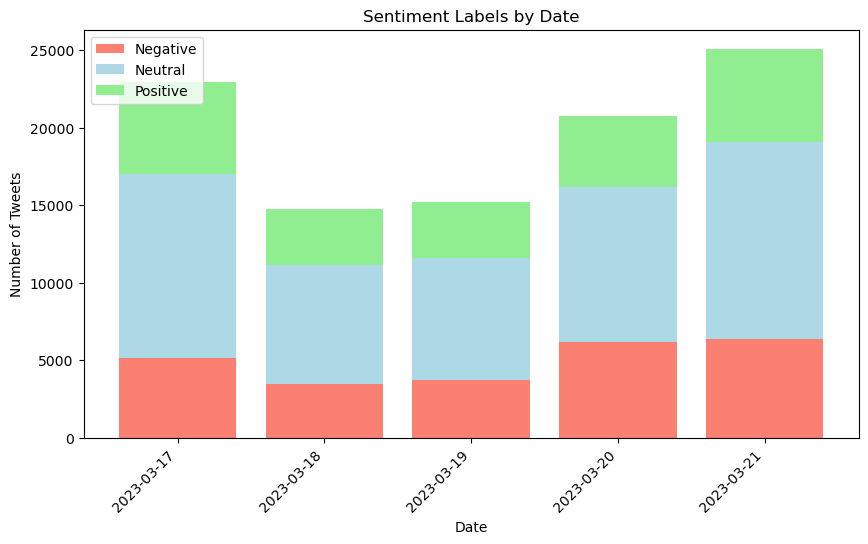

In [30]:
# pivot table to get the count of sentiment labels for each date
pivoted_df = pd.pivot_table(df[["OnlyDate", "sentiment_label"]], index='OnlyDate', columns='sentiment_label', aggfunc=len, fill_value=0)

# create bar chart
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(pivoted_df.index.values, pivoted_df['negative'], color='salmon', label='Negative')
ax.bar(pivoted_df.index.values, pivoted_df['neutral'], bottom=pivoted_df['negative'], color='lightblue', label='Neutral')
ax.bar(pivoted_df.index.values, pivoted_df['positive'], bottom=pivoted_df['neutral']+pivoted_df['negative'], color='lightgreen', label='Positive')

# set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets')
ax.set_title('Sentiment Labels by Date')

# rotate x-axis labels if needed
fig.autofmt_xdate(rotation=45)

# add legend
ax.legend(loc='upper left')

# show the plot
plt.show()

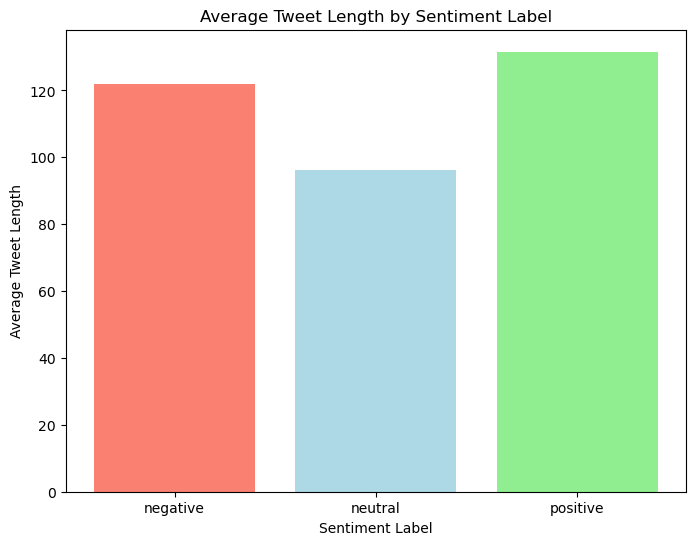

In [31]:
# calculate tweet lengths and add to dataframe
df['TweetLength'] = df['processed_tweet'].astype(str).apply(len)

# group by sentiment_label and calculate average tweet length
grouped = df.groupby('sentiment_label')['TweetLength'].mean()

# create bar chart
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(grouped.index, grouped.values, color=['salmon', 'lightblue', 'lightgreen'])

# set axis labels and title
ax.set_xlabel('Sentiment Label')
ax.set_ylabel('Average Tweet Length')
ax.set_title('Average Tweet Length by Sentiment Label')

# show the plot
plt.show()

### 4.4 Relationship between Retweet and Like

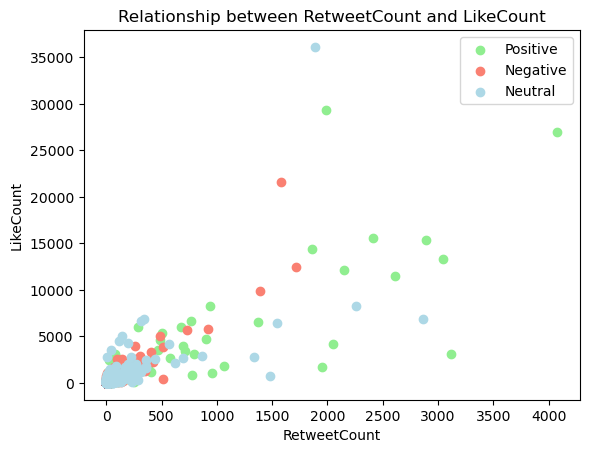

In [32]:
# Scatter plot for showing the relationship between RetweetCount and LikeCount variables, colored by sentiment_label
plt.scatter(df[df['sentiment_label'] == 'positive']['RetweetCount'], 
            df[df['sentiment_label'] == 'positive']['LikeCount'], c='lightgreen', label='Positive')

plt.scatter(df[df['sentiment_label'] == 'negative']['RetweetCount'], 
            df[df['sentiment_label'] == 'negative']['LikeCount'], c='salmon', label='Negative')

plt.scatter(df[df['sentiment_label'] == 'neutral']['RetweetCount'], 
            df[df['sentiment_label'] == 'neutral']['LikeCount'], c='lightblue', label='Neutral')

# Set the title, x and y axis labels
plt.title('Relationship between RetweetCount and LikeCount')
plt.xlabel('RetweetCount')
plt.ylabel('LikeCount')

# Add legend
plt.legend()

# Show the plot
plt.show()

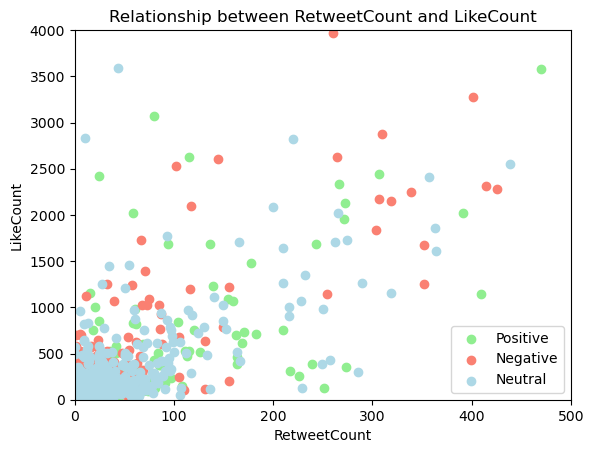

In [33]:
# Scatter plot for showing the relationship between RetweetCount and LikeCount variables, colored by sentiment_label
plt.scatter(df[df['sentiment_label'] == 'positive']['RetweetCount'], 
            df[df['sentiment_label'] == 'positive']['LikeCount'], c='lightgreen', label='Positive')

plt.scatter(df[df['sentiment_label'] == 'negative']['RetweetCount'], 
            df[df['sentiment_label'] == 'negative']['LikeCount'], c='salmon', label='Negative')

plt.scatter(df[df['sentiment_label'] == 'neutral']['RetweetCount'], 
            df[df['sentiment_label'] == 'neutral']['LikeCount'], c='lightblue', label='Neutral')

# Set the title, x and y axis labels
plt.title('Relationship between RetweetCount and LikeCount')
plt.xlabel('RetweetCount')
plt.ylabel('LikeCount')

# x and y axis limits
plt.xlim(0, 500)
plt.ylim(0, 4000)

# Lejantı ekle
plt.legend()

# Grafik göster
plt.show()

## 5. WordCloud

In [34]:
def plot_wordcloud(df, col):
    """
    Plots a wordcloud based on the text data in the specified column of a DataFrame.

    Args:
    df (pd.DataFrame): The DataFrame containing the text data.
    col (str): The name of the column containing the text data.

    Returns:
    None.
    """
    # Concatenate all text data in the specified column into a single string
    text = " ".join(i for i in df[col])

    # Create a wordcloud object
    wc = WordCloud(background_color="white",
                   max_words=1000,
                   contour_width=3,
                   contour_color="firebrick",
                   width=800, height=400).generate(text)

    # Plot the wordcloud
    plt.figure(figsize=(12,8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

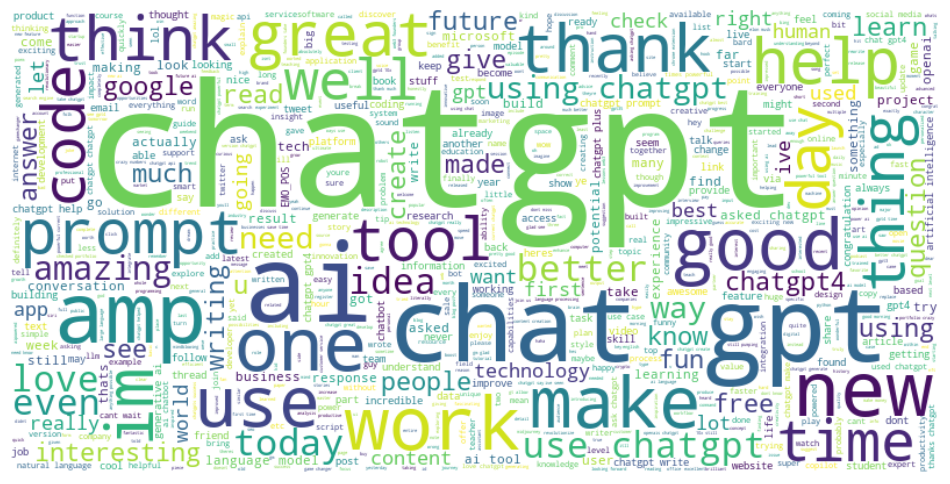

In [35]:
plot_wordcloud(df_positive, "processed_tweet_without_stopwords")

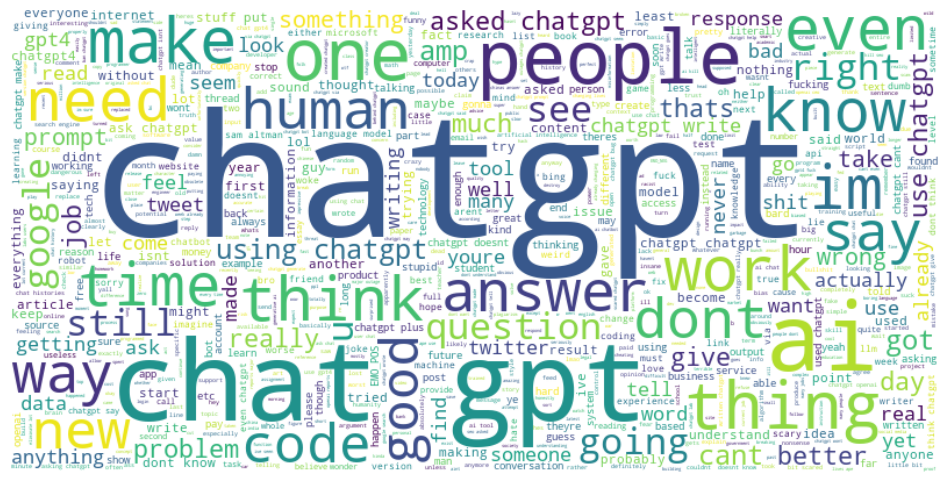

In [36]:
plot_wordcloud(df_negative, "processed_tweet_without_stopwords")

## 6. Negative argumentavie 

In [37]:
list(df_negative['Tweet'].head(30))

['ChatGPT is another woke machine. ',
 'i had chatgpt analyze my ocs after askin a bunch of questions and it was really fun in the moment but i literally have nothing i can do with all these answers besides think about them bc who wants to hear character analysis on characters you cant even see',
 ' You are a smart guy Mark.  You should be able to recognize ChatGPT is brought to you by the same MONORAIL! salesmen who sold you Crypto, self driving, and NFTs. The technology is not what they claim it is.  You can tell by how the use case is "writing" poems abt your pets.',
 'I find it really odd that #ChatGPT can return complete garbage to straight forward #mathematics questions \n\nThe calculations are wrong, and they are not Cullen primes! ',
 'Heard someone say “ChatGPT is already replacing software engineers.” \n\nI’m tired of y’all.',
 'Finally tried ChatGPT. I was disappointed in how unconvincing it was on LORs.',
 '  Time to gaslight chatgpt ',
 "man, the way they're sanitizing #Ch

In [38]:
get_top_words(df_negative, "processed_tweet_without_stopwords", 150)

[('chatgpt', 18721),
 ('chat', 3537),
 ('ai', 3201),
 ('gpt', 3121),
 ('like', 2759),
 ('dont', 1736),
 ('people', 1628),
 ('use', 1570),
 ('im', 1529),
 ('cant', 1371),
 ('even', 1346),
 ('get', 1322),
 ('using', 1219),
 ('write', 1197),
 ('know', 1154),
 ('think', 1136),
 ('one', 1136),
 ('make', 1036),
 ('would', 1032),
 ('asked', 1002),
 ('time', 953),
 ('could', 950),
 ('still', 875),
 ('doesnt', 852),
 ('work', 824),
 ('going', 821),
 ('really', 762),
 ('ask', 743),
 ('way', 732),
 ('gpt4', 732),
 ('see', 731),
 ('code', 722),
 ('need', 709),
 ('good', 708),
 ('wrong', 687),
 ('google', 687),
 ('answer', 685),
 ('much', 677),
 ('human', 677),
 ('openai', 662),
 ('right', 642),
 ('better', 640),
 ('also', 638),
 ('something', 631),
 ('got', 629),
 ('used', 620),
 ('new', 619),
 ('us', 615),
 ('never', 611),
 ('jobs', 596),
 ('thats', 583),
 ('already', 573),
 ('amp', 568),
 ('thing', 563),
 ('many', 557),
 ('ive', 556),
 ('bad', 543),
 ('say', 541),
 ('take', 524),
 ('things', 507